
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc


def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####

        K = self.num_samples_per_class
        N = self.num_classes

        all_image_batches = []
        all_label_batches = []

        for b in range(batch_size):
          char_folders = random.sample(folders, N)

          labels = list(range(N))
          random.shuffle(labels)
          imagepath_label_pairs = get_images(char_folders, labels, K, shuffle=False)

          train_image_labels = []
          test_image_labels  = [] 

          for i in range(N):
            train_image_labels += imagepath_label_pairs[(i*K):((i+1)*K)-1]
            test_image_labels.append(imagepath_label_pairs[((i+1)*K)-1])

          random.shuffle(train_image_labels)
          random.shuffle(test_image_labels)

          all_image_labels = train_image_labels + test_image_labels

          images = np.array([image_file_to_array(image_label[1], self.dim_input) for image_label in all_image_labels])
          labels = np.array([image_label[0] for image_label in all_image_labels], dtype = np.int8)

          labels_one_hot = np.zeros((labels.size, self.num_classes))
          labels_one_hot[np.arange(labels.size), labels] = 1

          labels_one_hot = np.vstack(labels_one_hot).reshape((self.num_samples_per_class, self.num_classes, -1))  # K, N, N

          images = np.vstack(images).reshape((self.num_samples_per_class, self.num_classes, -1))  # K x N x 784

          all_image_batches.append(images)
          all_label_batches.append(labels_one_hot)

        all_image_batches = np.stack(all_image_batches).astype(np.float32)
        all_label_batches = np.stack(all_label_batches).astype(np.float32)

        #############################
        #return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)
        return all_image_batches, all_label_batches


In [4]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers


class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        #self.cnn = tf.keras.layers.
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        in_zero = input_labels[:, -1:, :, :] - input_labels[:, -1:, :, :]
        labels = tf.concat([input_labels[:, :-1, :, :], in_zero], axis=1)
        inputs = tf.concat([input_images, labels], axis=-1)
        inputs = tf.reshape(inputs, [-1, self.num_classes * self.samples_per_class, input_images.shape[-1]+input_labels.shape[-1]])
        inputs = self.layer1(inputs)
        out  = self.layer2(inputs)
        out = tf.reshape(out, [-1, self.samples_per_class, self.num_classes, self.num_classes])
        #############################
        return out

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        #############################
        #### YOUR CODE GOES HERE ####
        preds = preds[:, -1, :, :]
        labels = labels[:, -1, :, :]
        losses = tf.keras.losses.categorical_crossentropy(labels, preds, from_logits=True)
        loss = tf.reduce_sum(losses)
        return loss
        #############################


@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss


def main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)

    train_loss = []
    test_loss  = []
    test_acc   = []

    for step in range(50000):
        i, l = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(i, l, o, optim)

        if (step+1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            i, l = data_generator.sample_batch('test', 100)
            pred, tls = train_step(i, l, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32))
            print("Test Accuracy", acc.numpy())
            train_loss.append(ls.numpy())
            test_loss.append(tls.numpy())
            test_acc.append(acc.numpy())

    return train_loss, test_loss, test_acc


In [5]:
#plotting utility 
import matplotlib.pyplot as plt
import seaborn as sns
#############################
#### YOUR CODE GOES HERE ####

def plot_metrics(x, y, num_classes, samples_per_class, exp_title):
  sns.set(style='darkgrid')
  fig, ax = plt.subplots(figsize = (10,7))
  x = np.array(x)
  y = np.array(y)
  ax.plot(x, y, c='b')

  ax.set_xlabel('Number of Iterations (x100)')
  ax.set_ylabel('Accuracy')
  #ax.set_xticks(x)

  #ax.legend(loc="best")
  ax.set_title('Few shot classification accuracy {}-way and {}-shot'.format(num_classes, samples_per_class))

  fig.savefig('/content/drive/MyDrive/CS330-MetaLearning/Hw1/blackbox_exp_{}.jpg'.format(exp_title))
#############################

*****Iter 100*****
Train Loss: 128.886 Test Loss: 804.9387
Test Accuracy 0.188
*****Iter 200*****
Train Loss: 128.61334 Test Loss: 804.8779
Test Accuracy 0.168
*****Iter 300*****
Train Loss: 128.77692 Test Loss: 804.56683
Test Accuracy 0.226
*****Iter 400*****
Train Loss: 128.71942 Test Loss: 804.75916
Test Accuracy 0.21
*****Iter 500*****
Train Loss: 128.75433 Test Loss: 804.6582
Test Accuracy 0.204
*****Iter 600*****
Train Loss: 128.7359 Test Loss: 804.67676
Test Accuracy 0.2
*****Iter 700*****
Train Loss: 128.751 Test Loss: 804.7041
Test Accuracy 0.234
*****Iter 800*****
Train Loss: 128.7542 Test Loss: 804.7054
Test Accuracy 0.2
*****Iter 900*****
Train Loss: 128.75421 Test Loss: 804.7217
Test Accuracy 0.208
*****Iter 1000*****
Train Loss: 128.76703 Test Loss: 804.67773
Test Accuracy 0.204
*****Iter 1100*****
Train Loss: 128.73013 Test Loss: 804.75464
Test Accuracy 0.19
*****Iter 1200*****
Train Loss: 128.76295 Test Loss: 804.7127
Test Accuracy 0.206
*****Iter 1300*****
Train Loss: 

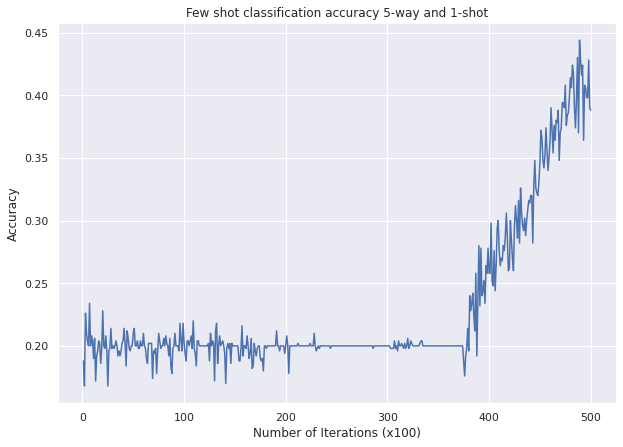

In [6]:
results = main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=2)
test_acc = results[2]
iterations = range(1, len(test_acc)+1)
plot_metrics(iterations, test_acc, num_classes=5, samples_per_class=1, exp_title='5-Way-1-shot-lr-0.001-optim_steps-50000-lstm_stack2-seed2')